In [81]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

import pytensor.tensor as pt
# from pymc import model_to_graphviz
from noaa.ghcnd import NOAAStore

## Load and Prep Data

In [82]:
store = NOAAStore()
stations = store.stations()
prcp = store.timeseries_universe(element='PRCP')

In [83]:
nyc_region_stations = {
    'USW00094728' : 'NYC', #	NY CITY CNTRL PARK
    'USW00014732' : 'LGA', #	LAGUARDIA AP
    'USW00014734' : 'EWR', #	NEWARK LIBERTY INTL AP
    'USW00094789' :	'JFK', #    JFK INTL AP
    'USW00094745' : 'HPN', #	WESTCHESTER CO AP
    'USW00094702' : 'BDR', #	IGOR I SIKORSKY MEM AP
    'USW00014737' : 'ABE', #	ALLENTOWN LEHIGH VLY INTL AP
    'USW00013739' : 'PHL', #	PHILA INTL AP
    # 'USW00014752' : 'HFD', #	HARTFORD BRAINARD FLD
    'USW00014777' : 'AVP', #	WILKES-BARRE/SCRANTON INTL AP
    'USW00014740' : 'BDL', #	HARTFORD-BRADLEY INTL AP
    'USW00013735' : 'MIV', #    MILLVILLE MUNI AP
    'USW00013781' : 'ILG', #	WILMINGTON NEW CASTLE CO AP
}

In [84]:
use_inch = True

nyc_region_stations_prcp = prcp.loc['1970-01-01':'2021-12-31'].unstack('id')[nyc_region_stations.keys()]
nyc_region_stations_prcp = nyc_region_stations_prcp.rename(columns = nyc_region_stations)

if use_inch:
   nyc_region_stations_prcp /= 25.4 

In [12]:
nyc_region_stations_info = stations.loc[nyc_region_stations.keys()]
nyc_region_stations_info.index = nyc_region_stations.values()
nyc_region_stations_info

,latitude,longitude,elevation,state,name,country
NYC,40.7789,-73.9692,42.7,NY,NY CITY CNTRL PARK,US
LGA,40.7794,-73.8803,3.0,NY,LAGUARDIA AP,US
EWR,40.6828,-74.1692,1.8,NJ,NEWARK LIBERTY INTL AP,US
JFK,40.6392,-73.7639,2.7,NY,JFK INTL AP,US
HPN,41.0622,-73.7044,112.8,NY,WESTCHESTER CO AP,US
BDR,41.1642,-73.1267,1.8,CT,IGOR I SIKORSKY MEM AP,US
ABE,40.6497,-75.4478,117.3,PA,ALLENTOWN LEHIGH VLY INTL AP,US
PHL,39.8733,-75.2269,2.1,PA,PHILA INTL AP,US
AVP,41.3336,-75.7228,289.9,PA,WILKES-BARRE/SCRANTON INTL AP,US
BDL,41.9375,-72.6819,51.5,CT,HARTFORD-BRADLEY INTL AP,US


In [24]:
prcp_annual_max = nyc_region_stations_prcp.groupby(lambda x:x.year).max()
prcp_annual_max_ = prcp_annual_max.stack('id')

In [26]:
station_idx, stations = prcp_annual_max_.reset_index()['id'].factorize(sort=False)

## Univariate - MLE

In [28]:
params = {}

for station in nyc_region_stations_prcp:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(nyc_region_stations_prcp[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

df_GEV = pd.DataFrame(params).T
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
NYC,2.849565,0.849387,0.165013,5.164225,8.698658,0.439263,1.852249
LGA,2.688285,0.711230,0.179968,4.661483,7.780254,0.379632,1.626144
EWR,2.807582,0.796469,0.193738,5.054195,8.719738,0.433010,1.789266
JFK,2.442320,0.631729,0.169551,4.173204,6.844026,0.321712,1.241714
HPN,2.954507,0.879069,0.054282,5.058636,7.548032,0.356584,1.312498
BDR,2.553274,0.835678,0.114518,4.698406,7.614018,0.388830,1.543457
ABE,2.430965,0.769113,0.241088,4.729058,8.911651,0.478099,2.376465
PHL,2.535497,0.842889,0.202374,4.937995,8.936782,0.486406,2.358225
AVP,2.042908,0.639845,0.177387,3.812570,6.593037,0.345213,1.568486
BDL,2.398925,0.748869,0.095092,4.278048,6.720309,0.330987,1.271838


In [22]:
df_GEV.mean()

mu        2.544383
sigma     0.750320
xi        0.177990
10y       4.618856
100y      7.925379
10yse     0.400330
100yse    1.748502
dtype: float64

## Probabilistic approach

Single Station

In [212]:
obs = prcp_annual_max['EWR'].to_numpy()
z = obs

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=3, sigma=3.0)
    σ = pm.HalfNormal("σ", sigma=1.0)
    ξ = pm.Normal('ξ', mu=0.0, sigma=0.2)
    # Exteme Value likelihood
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=z)
    # MCMC sampling
    trace = pm.sample(2000, target_accept = 0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


In [105]:
obs = prcp_annual_max['EWR'].to_numpy()

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=3, sigma=3.0)
    σ = pm.HalfNormal("σ", sigma=1.0)
    ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.2, lower=-0.99, upper=0.99)
    # GEV Likelihood
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=obs)
    # mcmc sampling
    trace = pm.sample(2000, target_accept = 0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


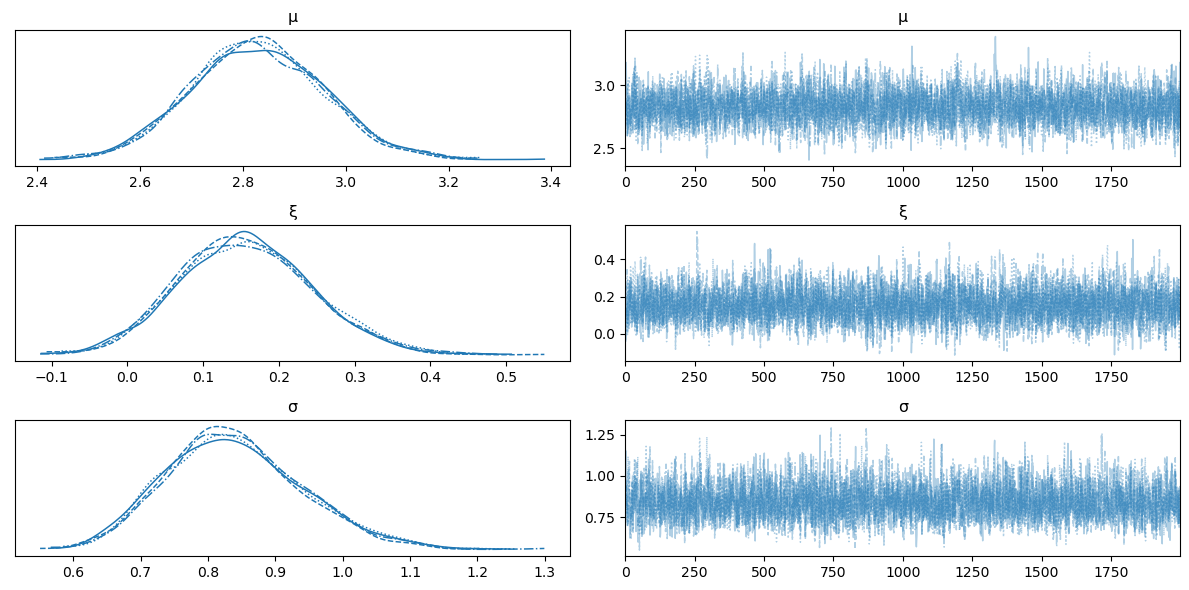

In [213]:
az.plot_trace(trace);
plt.tight_layout()

In [107]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,2.829,0.129,2.582,3.062,0.002,0.001,4032.0,4409.0,1.0
σ,0.842,0.107,0.651,1.039,0.002,0.001,3552.0,4325.0,1.0
ξ,0.157,0.089,-0.001,0.329,0.001,0.001,3841.0,3951.0,1.0


In [108]:
return_periods = np.logspace(1,2, num=50)

with model:
    rp = pm.ConstantData("rp", return_periods)
    rl = pm.Deterministic("rl", μ - σ/ξ * (1 - (-np.log(1 - 1/rp)) ** (-ξ)))
    posterior_pred = pm.sample_posterior_predictive(trace,var_names=['rl'])

Sampling: []


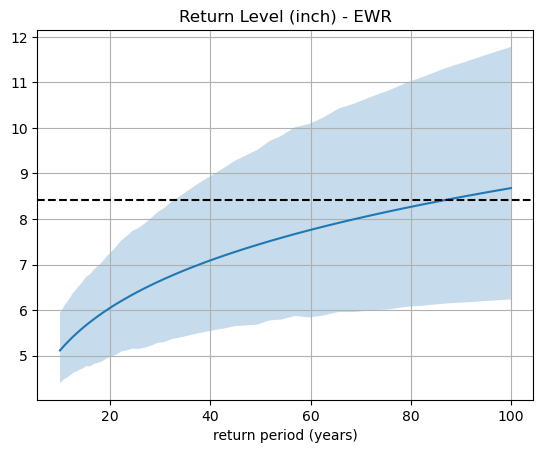

In [174]:
x = return_periods
y_data = az.summary(posterior_pred.posterior_predictive, var_names="rl",hdi_prob=0.95)
y_mean = y_data['mean']
y_L = y_data['hdi_2.5%']
y_U = y_data['hdi_97.5%']

plt.plot(x,y_mean)
plt.fill_between(x,y_L.to_numpy(),y_U.to_numpy(),alpha=0.25)
plt.axhline(y=prcp_annual_max['EWR'].max(), color='black', linestyle='--')
plt.xlabel('return period (years)')
plt.title('Return Level (inch) - EWR');
plt.grid()

# plt.xscale("log")

### Unpooled model

In [79]:
df_unpooled = prcp_annual_max[['NYC','LGA','EWR', 'JFK']]
max_obs = df_unpooled.to_numpy()

coords = {
    "station" : df_unpooled.columns,
    "obs" : df_unpooled .index,
    "rp" : return_periods 
}

with pm.Model(coords = coords) as unpooled_model:
    
    # Priors
    μ = pm.Normal("μ", mu=3.0, sigma=1.0, dims='station')
    σ = pm.HalfNormal("σ", sigma=0.7, dims='station')
    ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.25, lower=-0.99, upper=0.99, dims='station')

    # GEV Likelihood
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=max_obs, dims=('obs','station'))

    p = pm.ConstantData("p", 1/return_periods, dims="rp")
    rl = pm.Deterministic("rl", μ[:,None] - σ[:,None] / ξ[:,None] * (1 - (-np.log(1 - p[None:,])) ** (-ξ[:,None])), dims=('station','rp'))

    unpooled_trace = pm.sample(2000, target_accept = 0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


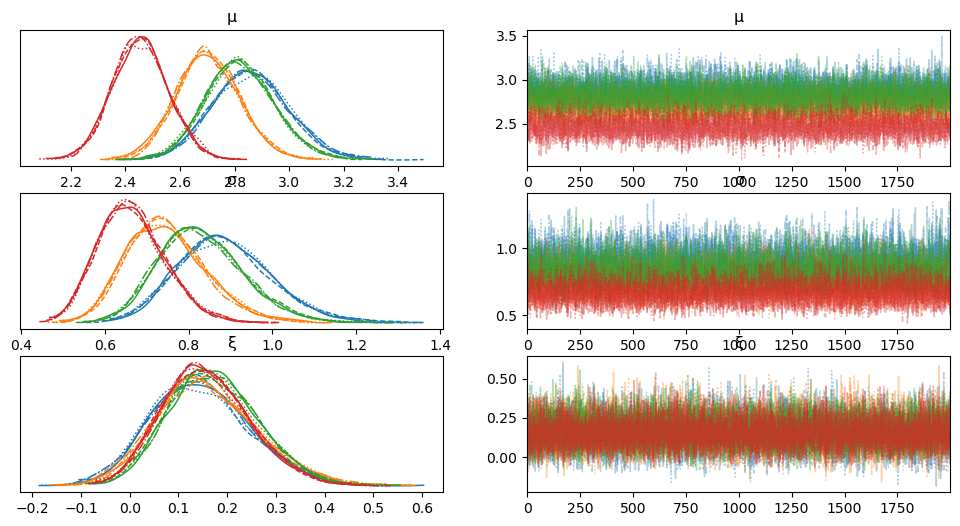

In [80]:
az.plot_trace(unpooled_trace, var_names=["μ", "σ", "ξ"]);

In [77]:
az.summary(unpooled_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[NYC],2.859,0.135,2.580,3.110,0.002,0.001,6317.0,6162.0,1.0
μ[LGA],2.701,0.114,2.486,2.926,0.001,0.001,6024.0,6032.0,1.0
μ[EWR],2.821,0.128,2.573,3.076,0.002,0.001,6317.0,6019.0,1.0
σ[NYC],0.883,0.110,0.681,1.105,0.001,0.001,6171.0,6361.0,1.0
σ[LGA],0.746,0.093,0.570,0.933,0.001,0.001,5821.0,5776.0,1.0
σ[EWR],0.833,0.104,0.639,1.038,0.001,0.001,6476.0,5921.0,1.0
ξ[NYC],0.148,0.103,-0.047,0.359,0.001,0.001,7339.0,5045.0,1.0
ξ[LGA],0.162,0.104,-0.043,0.362,0.001,0.001,5938.0,4181.0,1.0
ξ[EWR],0.173,0.094,0.001,0.362,0.001,0.001,6403.0,4607.0,1.0


Latent GP Prior

In [81]:
#upgrade to halversine distance
#https://en.wikipedia.org/wiki/Haversine_formula

class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * pt.stack(
            [
                pt.cos(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = pt.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return pt.sqrt(pt.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * pt.exp(-np.sqrt(3.0) * r)

In [198]:
station_idx, stations = prcp_annual_max_.reset_index()['id'].factorize(sort=False)

y_ = prcp_annual_max_.to_numpy()
X_lonlat = nyc_region_stations_info.loc[stations][['longitude','latitude']].to_numpy()

coords = {
    "cov_params": ["mu","sigma","xi"],
    "location" : ["x","y"],
    "lonlat" : ["longitude", "latitude"],
    "station" : stations,
    "obs" : prcp_annual_max_.reset_index().index,
    "rp" : return_periods,
}

with pm.Model(coords=coords) as gp_model:
    pt_idx = pm.ConstantData("station_idx", station_idx, dims="obs")
    pt_X_lonlat = pm.ConstantData("station_loc", X_lonlat, dims=("station","lonlat"))
    # gaussian process hyper parameters
    ℓ = pm.InverseGamma("ℓ", mu = 50.0, sigma = 50.0)
    η = pm.Gamma("η", mu=0.15, sigma=0.10, dims = "cov_params")
    # gaussian process prior for mu
    gp_μ = pm.gp.Latent(cov_func=η[0]**2 * Matern32Chordal(2, ℓ))
    μ_group = pm.Normal("μ_group", mu=3.0, sigma=1.0)
    μ = pm.Deterministic("μ", μ_group + gp_μ.prior("μ_gp", X=pt_X_lonlat), dims="station")
    # gaussian process prior for sigma
    gp_σ_log = pm.gp.Latent(cov_func=η[1]**2 * Matern32Chordal(2, ℓ))
    σ_log = gp_σ_log.prior("σ_log", X=pt_X_lonlat, dims="station")
    σ_log_group = pm.Normal("σ_log_group", mu=-1.0, sigma=2.0)
    σ = pm.Deterministic("σ", pm.math.exp(σ_log_group + σ_log),dims="station")
    # gaussian process prior for xi
    gp_ξ = pm.gp.Latent(cov_func=η[2]**2 * Matern32Chordal(2, ℓ))
    ξ_group =  pm.TruncatedNormal('ξ_group', mu=0.0, sigma=0.25, lower=-0.99, upper=0.99)
    ξ = pm.Deterministic("ξ", pm.math.tanh(ξ_group + gp_ξ.prior("ξ_gp", X=pt_X_lonlat)), dims="station")
    # likelihood for all observations
    gev = pmx.GenExtreme("gev", mu=μ[pt_idx], sigma=σ[pt_idx], xi=ξ[pt_idx], observed=y_, dims="obs")
    # return levels
    rl = pm.Deterministic("rl",
        μ[:,None] - σ[:,None] / ξ[:,None] * (1 - (-np.log(1 - p[None:,])) ** (-ξ[:,None])),
        dims=('station','rp')
    )
    # mcmc sampling
    gp_trace = pm.sample(1000, target_accept = 0.98, random_seed=314)

# pm.model_to_graphviz(gp_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, μ_group, μ_gp_rotated_, σ_log_rotated_, σ_log_group, ξ_group, ξ_gp_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 478 seconds.


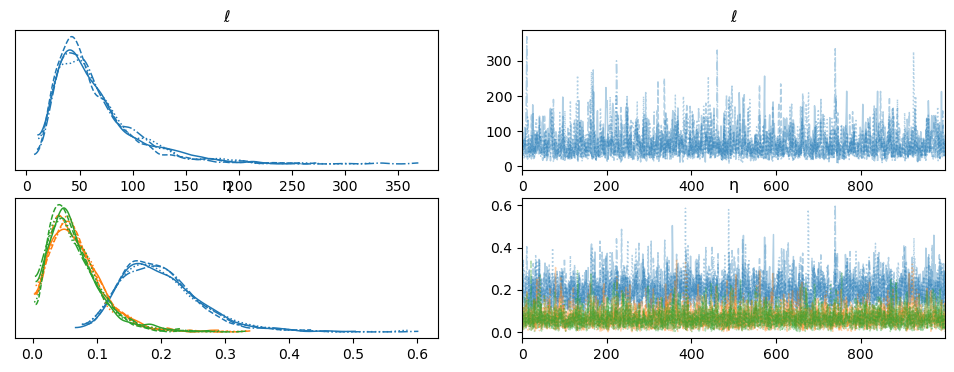

In [199]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

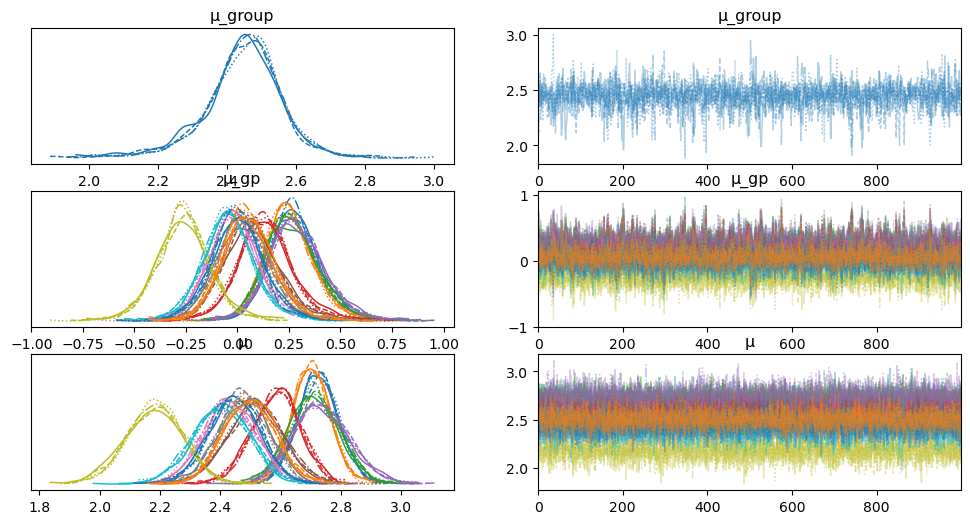

In [200]:
az.plot_trace(gp_trace, var_names=["μ_group","μ_gp","μ"]);

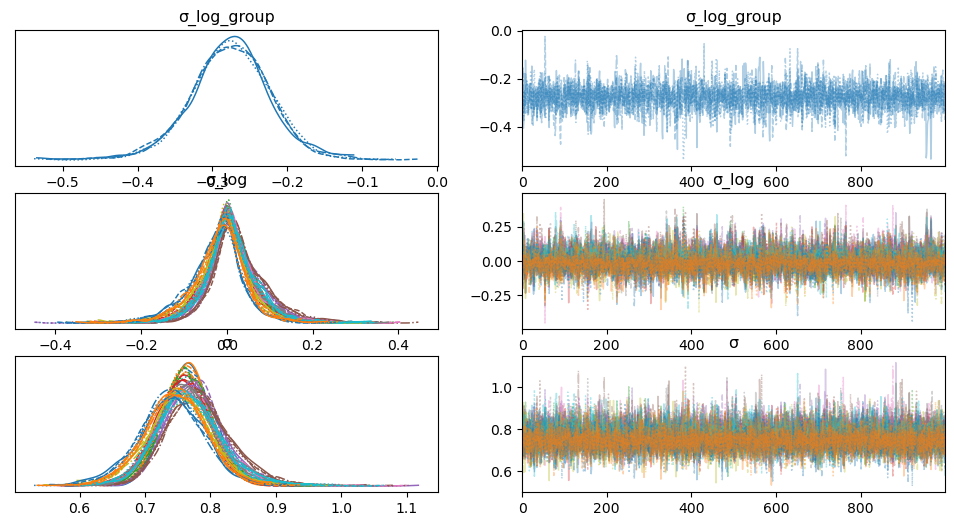

In [201]:
az.plot_trace(gp_trace, var_names=["σ_log_group","σ_log","σ"]);

In [180]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ,64.305,38.583,11.975,138.891,0.930,0.658,1791.0,2522.0,1.0
η[mu],0.200,0.063,0.094,0.323,0.001,0.001,2493.0,2405.0,1.0
η[sigma],0.068,0.042,0.007,0.149,0.001,0.001,2906.0,2440.0,1.0
η[xi],0.065,0.040,0.005,0.143,0.001,0.001,2639.0,2724.0,1.0


In [181]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[NYC],2.725,0.067,2.594,2.857,0.001,0.001,4447.0,3443.0,1.0
μ[LGA],2.701,0.062,2.583,2.827,0.001,0.001,4419.0,3570.0,1.0
μ[EWR],2.713,0.083,2.556,2.879,0.001,0.001,4840.0,3554.0,1.0
μ[JFK],2.585,0.080,2.426,2.733,0.001,0.001,3648.0,3573.0,1.0
μ[HPN],2.735,0.093,2.547,2.909,0.001,0.001,3901.0,3510.0,1.0
μ[BDR],2.515,0.093,2.332,2.695,0.001,0.001,4820.0,3390.0,1.0
μ[ABE],2.430,0.090,2.251,2.599,0.001,0.001,4554.0,3119.0,1.0
μ[PHL],2.478,0.085,2.316,2.643,0.001,0.001,4954.0,3420.0,1.0
μ[AVP],2.183,0.095,1.979,2.352,0.001,0.001,4574.0,3364.0,1.0
μ[BDL],2.403,0.094,2.205,2.570,0.001,0.001,5062.0,3497.0,1.0


In [202]:
x0, y0 = nyc_region_stations_info.loc['EWR'][['longitude','latitude']]
x1, y1 = nyc_region_stations_info.loc['PHL'][['longitude','latitude']]

dy = (y0-y1)/(x0-x1)

x_vals = np.linspace(-75.5,-72.5,100)
y_vals = y0 + dy * (x_vals-x0)

In [206]:
X_sample = np.array([x_vals,y_vals]).T

# X_sample = X_lonlat
jitter = 1e-6

with gp_model:
     p = pm.ConstantData("p", 1/return_periods, dims="rp")

     μ_pred = pm.Deterministic("μ_pred", μ_group + gp_μ.conditional("μ_gp_pred", Xnew=X_sample, jitter=jitter))
     σ_pred = pm.Deterministic("σ_pred", pm.math.exp(σ_log_group+gp_σ_log.conditional("σ_log_pred", Xnew=X_sample, jitter=jitter)))
     ξ_pred = pm.Deterministic("ξ_pred", pm.math.tanh(ξ_group+gp_ξ.conditional("ξ_gp_pred", Xnew=X_sample, jitter=jitter)))

     rl_100_pred = pm.Deterministic("rl_100_pred", μ_pred - σ_pred / ξ_pred * (1 - (-np.log(1 - 1/100)) ** (-ξ_pred)))

     pp_gp = pm.sample_posterior_predictive(gp_trace,var_names=['rl_100_pred'])

Sampling: [μ_gp_pred, ξ_gp_pred, σ_log_pred]


In [ ]:
# pm.model_to_graphviz(gp_model)

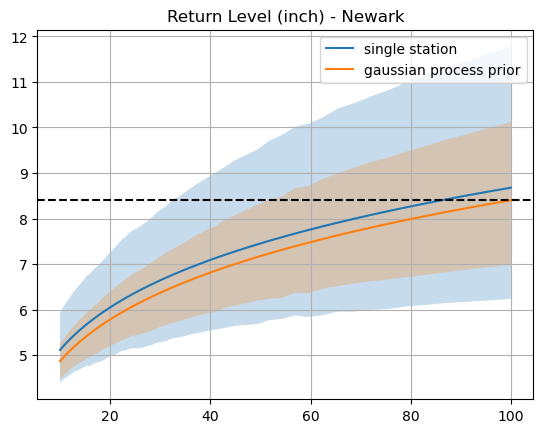

In [215]:
station = 'EWR'

x = return_periods
y_data = az.summary(posterior_pred.posterior_predictive, var_names="rl",hdi_prob=0.95)
y_mean = y_data['mean']
y_L = y_data['hdi_2.5%']
y_U = y_data['hdi_97.5%']

z_data = az.summary(gp_trace, var_names="rl",coords={'station':station},hdi_prob=0.95)
z_mean = z_data['mean']
z_L = z_data['hdi_2.5%']
z_U = z_data['hdi_97.5%']

plt.plot(x,y_mean,label='single station')
plt.fill_between(x,y_L.to_numpy(),y_U.to_numpy(),alpha=0.25)

plt.plot(x,z_mean,label='gaussian process prior')
plt.fill_between(x,z_L.to_numpy(),z_U.to_numpy(),alpha=0.25)
plt.legend()

plt.axhline(y=prcp_annual_max['EWR'].max(), color='black', linestyle='--')
plt.title('Return Level (inch) - Newark');
plt.grid()

# plt.xscale("log")

In [166]:
az.summary(gp_trace, var_names="rl",coords={'rp':100.0},hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rl[NYC],8.331,0.711,7.101,9.774,0.010,0.007,5621.0,4020.0,1.0
rl[LGA],8.264,0.709,7.009,9.684,0.010,0.007,5643.0,3885.0,1.0
rl[EWR],8.422,0.799,7.057,10.066,0.011,0.008,5961.0,3930.0,1.0
rl[JFK],8.089,0.788,6.624,9.666,0.011,0.008,5172.0,3869.0,1.0
rl[HPN],8.271,0.845,6.767,9.987,0.013,0.009,4576.0,3681.0,1.0
rl[BDR],7.990,0.879,6.398,9.832,0.013,0.009,4731.0,3721.0,1.0
rl[ABE],8.252,1.019,6.594,10.357,0.015,0.011,5055.0,3355.0,1.0
rl[PHL],8.467,1.018,6.608,10.509,0.015,0.011,4816.0,3639.0,1.0
rl[AVP],7.613,1.047,5.694,9.605,0.016,0.011,4876.0,3465.0,1.0
rl[BDL],7.709,1.000,5.797,9.600,0.016,0.011,4126.0,3206.0,1.0


In [208]:
df_ne_line = az.summary(pp_gp.posterior_predictive, var_names="rl_100_pred",hdi_prob=0.95)

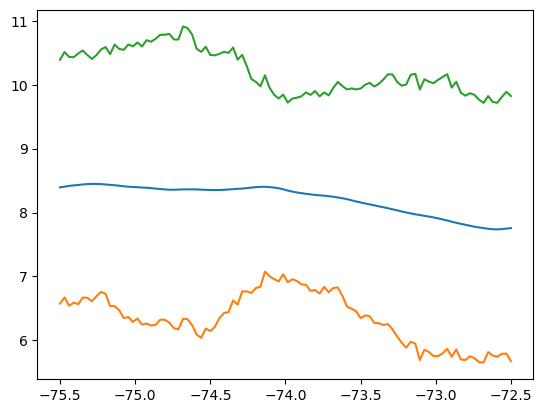

In [211]:
plt.plot(x_vals,df_ne_line['mean'])
plt.plot(x_vals,df_ne_line['hdi_2.5%'])
plt.plot(x_vals,df_ne_line['hdi_97.5%'])